# MS009 Preprocess
Created: 01/25/2024 \
Updated: 09/13/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS009'
subj_format = ['edf']
subj_site = ['MSSM']


In [6]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

09142024


# Make mne_data


### Load and resample data


In [7]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/raw/MS009_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2207039  =      0.000 ...  2155.312 secs...


In [8]:
mne_data

<RawEDF | MS009_SWB.edf, 276 x 2207040 (2155.3 s), ~4.54 GB, data loaded>

In [8]:
# mne_data.ch_names

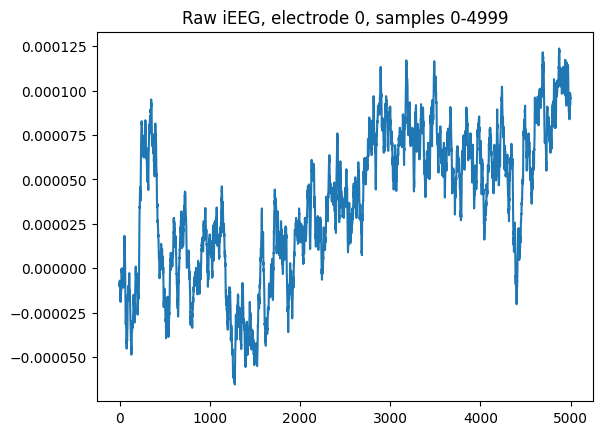

In [9]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [10]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   45.6s finished


<RawEDF | MS009_SWB.edf, 276 x 1077656 (2155.3 s), ~2.22 GB, data loaded>

### Notch filter line noise

In [11]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    9.2s finished


<RawEDF | MS009_SWB.edf, 276 x 1077656 (2155.3 s), ~2.22 GB, data loaded>

### Photodiode
- examine photodiode 

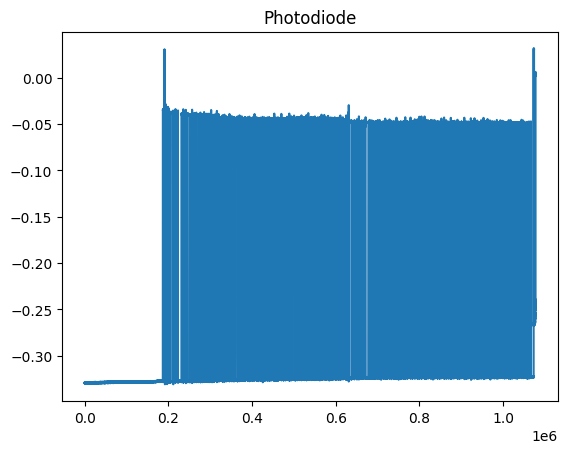

In [12]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [13]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/photodiode.fif
[done]


In [14]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS009_SWB.edf, 275 x 1077656 (2155.3 s), ~2.21 GB, data loaded>

### Anatomical Localization

In [15]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS009_SWB.edf, 275 x 1077656 (2155.3 s), ~2.21 GB, data loaded>

In [16]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32sg_L,-2.198512,42.942225,0.399996,-2.171989,31.060445,-9.573366,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS10,A9l_L,-12.191809,54.538567,42.799993,-12.589239,50.871375,37.637815,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 C,WM,NaN
2,LaCaS11,A9l_L,-13.391005,56.138062,47.999993,-13.741458,53.387483,43.456687,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 C,OOB,NaN
3,LaCaS12,Unknown,-15.389664,57.337684,51.599993,-15.762398,55.196659,47.463093,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32sg_L,-3.397708,44.141846,5.199996,-3.528236,33.282432,-4.187506,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,LpTpT7,A20cl_L,-59.759902,-25.836078,-8.400004,-58.231368,-43.255961,-9.333006,White,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L ITG,Left inferior middle temporal gyrus E,WM,NaN
98,LpTpT8,A21c_L,-64.556684,-26.635826,-7.600004,-63.062459,-44.205698,-8.202658,Gray,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left inferior middle temporal gyrus E,WM,NaN
99,LpTpT9,A37dl_L,-69.753199,-27.435573,-6.800004,-68.357228,-45.185994,-7.211913,Gray,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left inferior middle temporal gyrus E,NaN,NaN
100,uLcPpP,A23d_L,-6.995295,-25.836078,21.599995,-5.040701,-35.483679,26.399148,Gray,Left PCgG posterior cingulate gyrus,Unknown,L PCC,L CG,Left cingulate gyrus O,NaN,NaN


In [17]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAgIT1',
 'LAgIT10',
 'LAgIT11',
 'LAgIT12',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LaIaS1',
 'LaIaS10',
 'LaIaS11',
 'LaIaS12',
 'LaIaS2',
 'LaIaS3',
 'LaIaS4',
 'LaIaS5',
 'LaIaS6',
 'LaIaS7',
 'LaIaS8',
 'LaIaS9',
 'LHpIT1',
 'LHpIT10',
 'LHpIT11',
 'LHpIT12',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LpCpP1',
 'LpCpP2',
 'LpCpP3',
 'LpCpP4',
 'LpCpP5',
 'LpCpP6',
 'LpCpP7',
 'LpCpP8',
 'LpCpP9',
 'LpIpM1',
 'LpIpM10',
 'LpIpM11',
 'LpIpM12',
 'LpIpM13',
 'LpIpM14',
 'LpIpM2',
 'LpIpM3',
 'LpIpM4',
 'LpIpM5',
 'LpIpM6',
 'LpIpM7',
 'LpIpM8',
 'L

In [18]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lmoif1', 'lmoif2', 'lmoif3', 'lmoif4', 'lmoif5', 'lmoif6', 'lmoif7', 'lmoif8', 'lmoif9', 'c10', 'c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'c110', 'c111', 'c112', 'c113', 'c114', 'c115', 'c116', 'c117', 'c118', 'c119', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c150', 'c151', 'c152', 'c153', 'c154', 'c155', 'c156', 'c157', 'c158', 'c159', 'c160', 'c161', 'c162', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c

In [19]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [20]:
unmatched_seeg #make sure there are no unmatched names


[]

In [21]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [22]:
new_name_dict #make sure this passes the eye test 


{'lmoif1': 'lmolf1',
 'lmoif2': 'lmolf2',
 'lmoif3': 'lmolf3',
 'lmoif4': 'lmolf4',
 'lmoif5': 'lmolf5',
 'lmoif6': 'lmolf6',
 'lmoif7': 'lmolf7',
 'lmoif8': 'lmolf8',
 'lmoif9': 'lmolf9',
 'c10': 'c10',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'lmcms1': 'lmcms1',
 'lmcms2': 'lmcms2',
 'lmcms3': 'lmcms3',
 'lmcms4': 'lmcms4',
 'lmcms5': 'lmcms5',
 'lmcms6': 'lmcms6',
 'lmcms7': 'lmcms7',
 'lmcms8': 'lmcms8',
 'lmcms9': 'lmcms9',
 'lmcms10': 'lmcms10',
 'lagit1': 'lagit1',
 'lagit2': 'lagit2',
 'lagit3': 'lagit3',
 'lagit4': 'lagit4',
 'lagit5': 'lagit5',
 'lagit6': 'lagit6',
 'lagit7': 'lagit7',
 'lagit8': 'lagit8',
 'lagit9': 'lagit9',
 'lagit10': 'lagit10',
 'lagit11': 'lagit11',
 'lagit12': 'lagit12',
 'lhpit1': 'lhpit1',
 'lhpit2': 'lhpit2',
 'lhpit3': 'lhpit3',
 'lhp

In [23]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS009_SWB.edf, 275 x 1077656 (2155.3 s), ~2.21 GB, data loaded>

In [24]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 100 left sEEG and 0 right sEEG electrodes
We have a total of 100 sEEG electrodes


In [25]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS009_SWB.edf, 275 x 1077656 (2155.3 s), ~2.21 GB, data loaded>

In [26]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS009_SWB.edf, 100 x 1077656 (2155.3 s), ~822.3 MB, data loaded>

In [27]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS009_SWB.edf, 100 x 1077656 (2155.3 s), ~822.3 MB, data loaded>

In [28]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [29]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [30]:
probe_ch_counts

{'lacas': 12,
 'lagit': 12,
 'laias': 12,
 'lhpit': 12,
 'lmcms': 10,
 'lmolf': 9,
 'lpcpp': 9,
 'lpipm': 14,
 'lptpt': 10,
 'ulcppp': 1,
 'ulmolf': 1}

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [31]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

In [32]:
#  %matplotlib notebook
# fig = mne_data.plot(start=0, duration=1000, n_channels=20, scalings=mne_data._data.max()/50)
# fig.fake_keypress('a')

In [33]:
# mne_data.info['bads'] = ['lptpt10', 'lptpt9', 'lptpt8']#current 04/04/2024

## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [31]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [32]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/raw_ieeg.fif...
    Range : 0 ... 1077655 =      0.000 ...  2155.310 secs
Ready.
Reading 0 ... 1077655  =      0.000 ...  2155.310 secs...


### Bipolar Re-ref

In [33]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=60, n_times=1077656
    Range : 0 ... 1077655 =      0.000 ...  2155.310 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas4-lacas5, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lacas9-lacas10, lagit1-lagit2, lagit2-lagit3, lagit3-lagit4, lagit4-lagit5, lagit8-lagit9, lagit9-lagit10, laias1-laias2, laias2-laias3, laias3-laias4, laias4-laias5, laias6-laias7, laias7-laias8, laias8-laias9, laias9-laias10, laias10-laias11, lhpit1-lhpit2, lhpit2-lhpit3, lhpit3-lhpit4, lhpit7-lhpit8, lhpit8-lhpit9, lhpit9-lhpit10, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms7-lmcms8, lmolf1-lmolf2, lmolf2-lmolf3, lmolf3-lmolf4, lmolf4-lmolf5, lmolf5-lmolf6, lpcpp5-lpcpp6, lpcpp6-lpcpp7, lpcpp7-lpcpp8, lpcpp8-lpcpp9, lpipm1-lpipm2, lp

In [34]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 60 x 1077656 (2155.3 s), ~493.4 MB, data loaded>

In [35]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas5-lacas6',
 'lacas6-lacas7',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'lacas9-lacas10',
 'lagit1-lagit2',
 'lagit2-lagit3',
 'lagit3-lagit4',
 'lagit4-lagit5',
 'lagit8-lagit9',
 'lagit9-lagit10',
 'laias1-laias2',
 'laias2-laias3',
 'laias3-laias4',
 'laias4-laias5',
 'laias6-laias7',
 'laias7-laias8',
 'laias8-laias9',
 'laias9-laias10',
 'laias10-laias11',
 'lhpit1-lhpit2',
 'lhpit2-lhpit3',
 'lhpit3-lhpit4',
 'lhpit7-lhpit8',
 'lhpit8-lhpit9',
 'lhpit9-lhpit10',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms7-lmcms8',
 'lmolf1-lmolf2',
 'lmolf2-lmolf3',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lpcpp5-lpcpp6',
 'lpcpp6-lpcpp7',
 'lpcpp7-lpcpp8',
 'lpcpp8-lpcpp9',
 'lpipm1-lpipm2',
 'lpipm2-lpipm3',
 'lpipm3-lpipm4',
 'lpipm4-lpipm5',
 'lpipm5-lpipm6',
 'lpipm7-lpipm8',
 'lpipm8-lpipm9',
 'lpipm9-lpipm10',
 'lpipm10-lpipm11',
 'lpipm11-lpipm12',
 'lptpt1-lptpt2',

# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


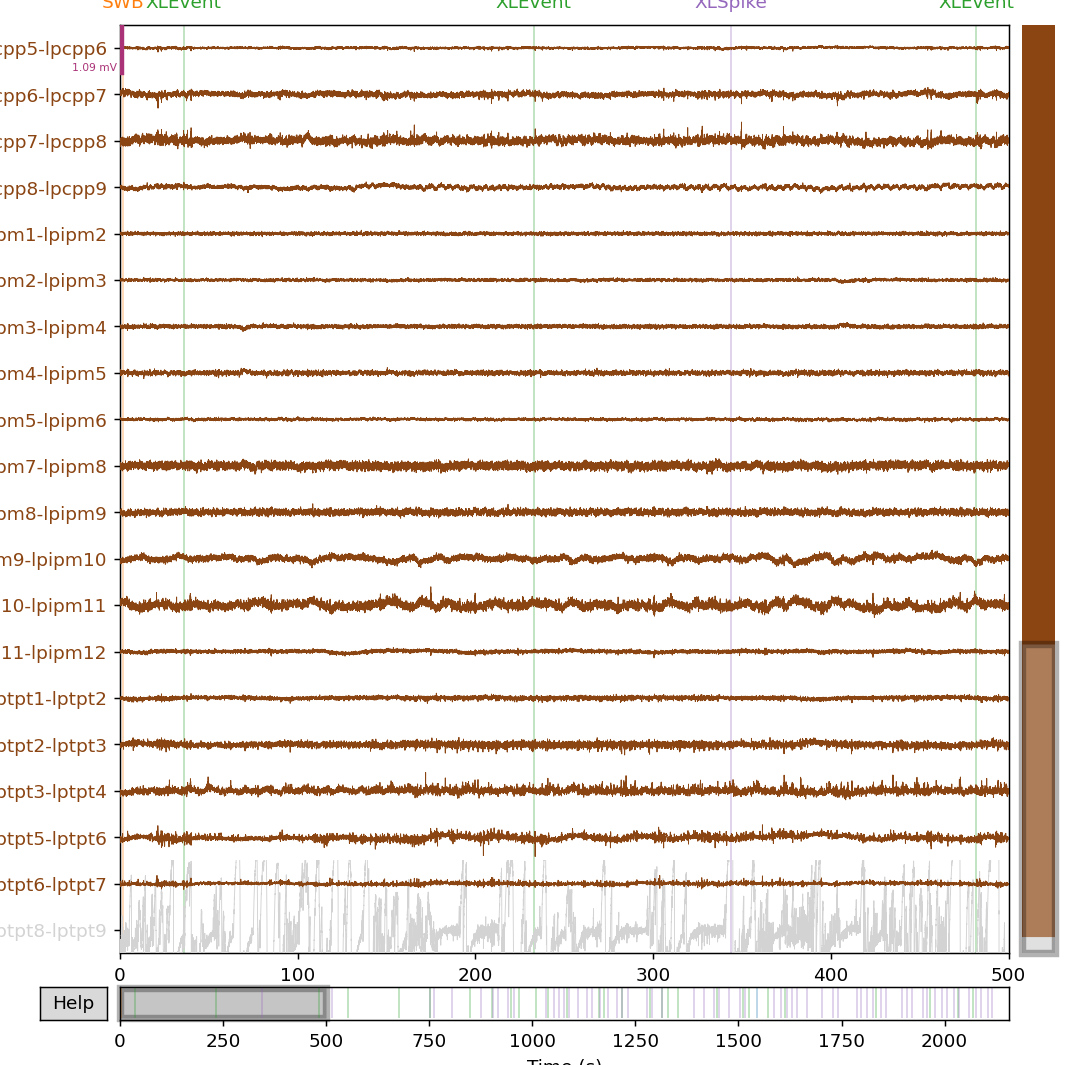

<IPython.core.display.Javascript object>


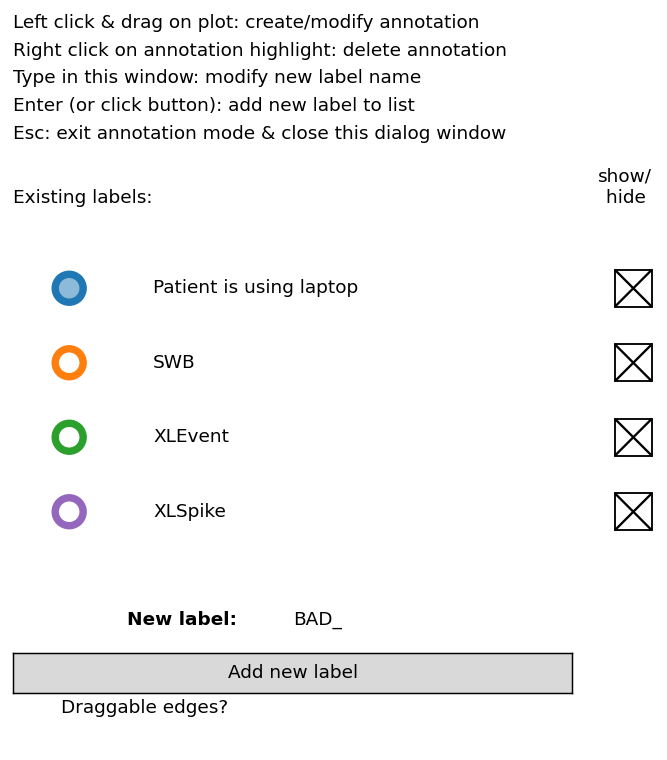

In [36]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=20, scalings=mne_data_bp_reref._data.max()/20)
fig.fake_keypress('a')

Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


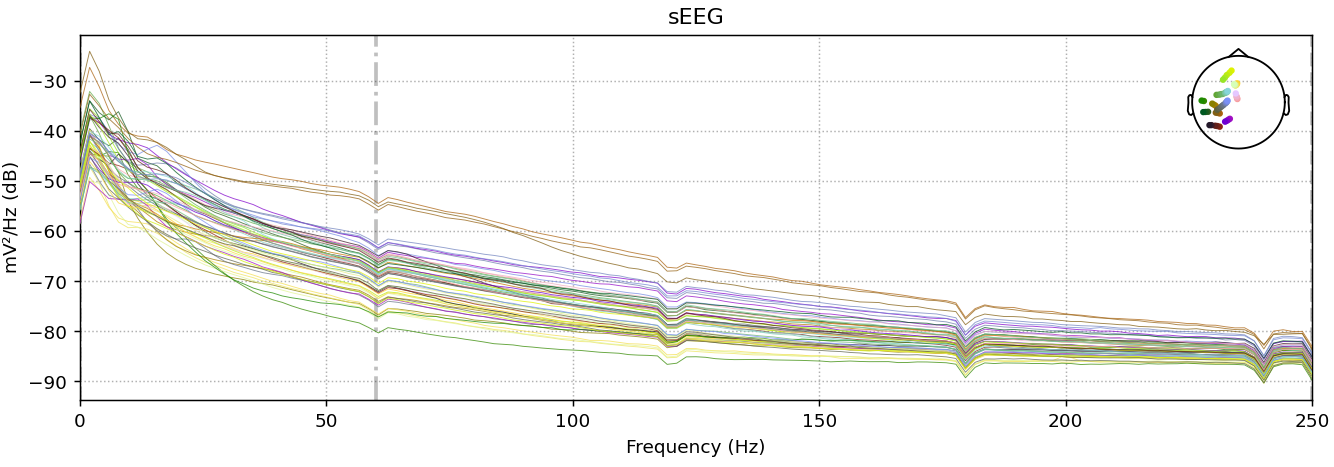

<IPython.core.display.Javascript object>


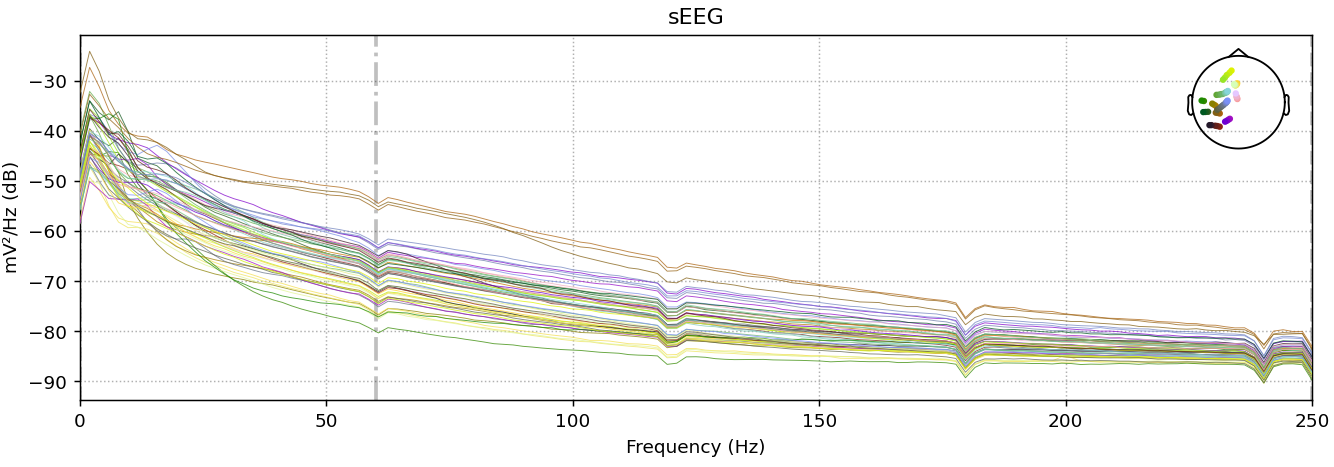

In [37]:
# %matplotlib notebook
mne_data_bp_reref.compute_psd().plot()

In [38]:
print(mne_data_bp_reref.info['bads'],date)

['lptpt8-lptpt9'] 05212024


## Save Reref Data

In [39]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/bp_ref_ieeg.fif
[done]


In [40]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [7]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,126.0,loss,487.991107,488.002470,491.374137,491.381716,3.371668,-0.4,-1.12,...,0.72,0.72,0.00,0.00,0.72,0.72,-1.12,-1.12,0.00,0.000
1,2,11.0,mix,498.702764,498.713769,503.617654,505.633411,4.903885,0.0,-0.50,...,-0.76,-0.50,-0.76,-0.50,0.00,0.00,0.26,0.00,0.00,-0.380
2,3,71.0,gain,510.488058,510.495536,512.947095,512.954104,2.451559,0.4,0.00,...,-0.27,-0.27,-0.27,-0.27,0.00,0.00,0.67,0.67,0.00,0.000
3,4,122.0,loss,528.870588,528.877171,533.651904,535.668326,4.774734,-0.4,-0.73,...,-0.73,-0.33,-0.73,-0.33,0.00,0.00,0.00,-0.40,0.00,-0.365
4,5,89.0,gain,540.627087,540.634914,544.163011,544.170808,3.528097,0.5,0.00,...,-1.60,-1.60,-1.60,-1.60,0.00,0.00,2.10,2.10,0.00,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,79.0,gain,2115.315997,2115.316765,2116.616084,2118.631844,1.299319,0.4,0.00,...,1.68,1.28,0.00,0.00,1.68,1.28,0.00,0.40,0.84,0.000
146,147,43.0,mix,2123.179684,2123.180414,2124.845392,2124.849921,1.664978,0.0,-0.80,...,-1.60,-1.60,-1.60,-1.60,0.00,0.00,1.60,1.60,0.00,0.000
147,148,97.0,gain,2134.506307,2134.513881,2135.589560,2137.605146,1.075679,0.6,0.00,...,-1.90,-0.60,-1.90,-0.60,0.00,0.00,1.90,0.60,0.00,-0.950
148,149,20.0,mix,2142.626716,2142.634110,2143.902462,2143.909570,1.268351,0.0,-0.80,...,0.80,0.80,0.00,0.00,0.80,0.80,-0.80,-0.80,0.00,0.000


In [8]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/photodiode.fif...
Isotrak not found
    Range : 0 ... 1077655 =      0.000 ...  2155.310 secs
Ready.
Reading 0 ... 1077655  =      0.000 ...  2155.310 secs...


In [9]:
photodiode_data

<Raw | photodiode.fif, 1 x 1077656 (2155.3 s), ~8.2 MB, data loaded>

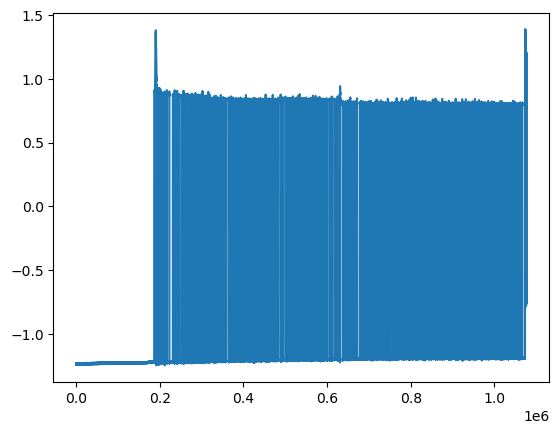

In [10]:
plt.plot(zscore(photodiode_data._data[0,:]))
plt.show()

In [11]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.75

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 120 of 159 pulses


In [12]:
print(slope, offset,smoothSize,windSize,height)

0.9999927999185265 -25.48071366087015 11 15 0.75


In [13]:
0.9999927999185265-0.99999206

7.399185265599684e-07

In [14]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

150

In [15]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

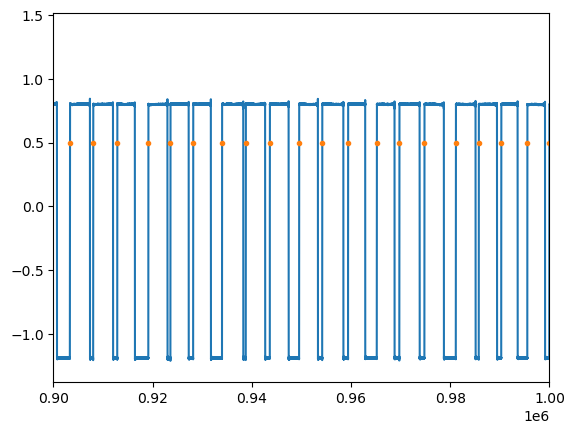

In [16]:
plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')

plt.xlim([900000,1000000])
plt.show()

In [17]:
photodiode_params = np.array([slope, offset])
diode_info_fname  = f'{neural_dir}diode_info/{subj_id}_diode_info'
np.save(diode_info_fname, photodiode_params)


# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

In [18]:
diode_info_fname  = f'{neural_dir}diode_info/{subj_id}_diode_info.npy'
photodiode_params = np.load(diode_info_fname)

photodiode_params

array([  0.9999928 , -25.48071366])

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [50]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,126.0,loss,487.991107,488.002470,491.374137,491.381716,3.371668,-0.4,-1.12,...,0.72,0.72,0.00,0.00,0.72,0.72,-1.12,-1.12,0.00,0.000
1,2,11.0,mix,498.702764,498.713769,503.617654,505.633411,4.903885,0.0,-0.50,...,-0.76,-0.50,-0.76,-0.50,0.00,0.00,0.26,0.00,0.00,-0.380
2,3,71.0,gain,510.488058,510.495536,512.947095,512.954104,2.451559,0.4,0.00,...,-0.27,-0.27,-0.27,-0.27,0.00,0.00,0.67,0.67,0.00,0.000
3,4,122.0,loss,528.870588,528.877171,533.651904,535.668326,4.774734,-0.4,-0.73,...,-0.73,-0.33,-0.73,-0.33,0.00,0.00,0.00,-0.40,0.00,-0.365
4,5,89.0,gain,540.627087,540.634914,544.163011,544.170808,3.528097,0.5,0.00,...,-1.60,-1.60,-1.60,-1.60,0.00,0.00,2.10,2.10,0.00,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,79.0,gain,2115.315997,2115.316765,2116.616084,2118.631844,1.299319,0.4,0.00,...,1.68,1.28,0.00,0.00,1.68,1.28,0.00,0.40,0.84,0.000
146,147,43.0,mix,2123.179684,2123.180414,2124.845392,2124.849921,1.664978,0.0,-0.80,...,-1.60,-1.60,-1.60,-1.60,0.00,0.00,1.60,1.60,0.00,0.000
147,148,97.0,gain,2134.506307,2134.513881,2135.589560,2137.605146,1.075679,0.6,0.00,...,-1.90,-0.60,-1.90,-0.60,0.00,0.00,1.90,0.60,0.00,-0.950
148,149,20.0,mix,2142.626716,2142.634110,2143.902462,2143.909570,1.268351,0.0,-0.80,...,0.80,0.80,0.00,0.00,0.80,0.80,-0.80,-0.80,0.00,0.000


In [51]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('safe', 491.3741374999991, 491.3817155999968),
 ('gamble', 503.61765399999786, 505.6334105999995),
 ('safe', 512.947094799998, 512.9541044999969),
 ('gamble', 533.6519043999979, 535.6683256999968),
 ('safe', 544.1630114, 544.1708084999991),
 ('safe', 553.7078787999999, 553.7107909999977),
 ('safe', 573.2484942999981, 573.2563024999981),
 ('safe', 582.5759691999992, 582.5809382999978),
 ('gamble', 590.9056105999989, 592.9206785999995),
 ('safe', 604.5483958999976, 604.5562963999982),
 ('gamble', 614.3600020999984, 616.3756658999991),
 ('safe', 624.6710248999989, 624.6780442999989),
 ('gamble', 639.4300642999988, 641.4451521999981),
 ('safe', 652.1401198999993, 652.1479077000004),
 ('gamble', 661.7516099999993, 663.7677589999985),
 ('gamble', 679.3416968999991, 681.357656199998),
 ('safe', 688.3213894, 688.326915499998),
 ('safe', 697.665852099999, 697.6729522999995),
 ('gamble', 712.1576628000003, 714.1738183999987),
 ('gamble', 723.4023517999995, 725.4174238999985),
 ('safe', 733.679

In [52]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0       493.374137
1       505.617654
2       514.947095
3       535.651904
4       546.163011
          ...     
145    2118.616084
146    2126.845392
147    2137.589560
148    2145.902462
149    2155.365086
Name: CpeOnset, Length: 150, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [53]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [54]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [55]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [56]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/bp_ref_ieeg.fif...
    Range : 0 ... 1077655 =      0.000 ...  2155.310 secs
Ready.
Reading 0 ... 1077655  =      0.000 ...  2155.310 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.5s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/bp_ref_ieeg.fif...
    Range : 0 ... 1077655 =      0.000 ...  2155.310 secs
Ready.
Reading 0 ... 1077655  =      0.000 ...  2155.310 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.2s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS009/bp_ref_ieeg.fif...
    Range : 0 ... 1077655 =      0.000 ...  2155.310 secs
Ready.
Reading 0 ... 1077655  =      0.000 ...  2155.310 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.2s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 2501 original time points ...
0 bad epochs dropped


In [57]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~103.2 MB, data loaded,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~86.0 MB, data loaded,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~171.8 MB, data loaded,
  'CpeOnset': 150>}

In [58]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [59]:
behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
                'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
                'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
                'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [60]:
for event in evs.keys():

    event_metadata = pd.DataFrame(columns=behav_params)
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Adding metadata with 19 columns
Adding metadata with 19 columns
Adding metadata with 19 columns


### Save raw epoched data 

In [61]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


In [62]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~103.2 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~86.0 MB, data loaded, with metadata,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~171.8 MB, data loaded, with metadata,
  'CpeOnset': 150>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [63]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [64]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [65]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:   12.1s finished


Adding metadata with 19 columns


In [66]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 59, ~1014.9 MB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [67]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:   10.8s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
Not setting metadata
Adding metadata with 19 columns
Compute baselined TFR for epoch:  CpeOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:   19.7s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
Not setting metadata
Adding metadata with 19 columns


In [68]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 59, ~508.5 MB>,
 'CpeOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 59, ~2.97 GB>}

In [69]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 59, ~508.5 MB>

In [70]:
power_epochs['CpeOnset']

<EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 59, ~2.97 GB>

# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [71]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/single_elec_tfrs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


05212024 -25.48071366087015


In [72]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    

Plot TFR for epoch:  DecisionOnset
Plot TFR for epoch:  CpeOnset
